<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Single cell effects
This aggregates information across a relatively small number of pre-synaptic cells and a large number of post-synaptic cells.  Might the relationship between connection and correlation vary with pre or post-synaptic cell? If certain cells are more visually responsive, or are leaders vs followers, or chorists vs soloists, this might lead to very different synaptic plasticity.  Checking whether individual cells (either pre or post) have more shifted distributions than others could provide some evidence for this.  Keep in mind that the number of connection reconstructed will effect the statistical power you have to detect changes of different sizes.

In [4]:
import numpy as np
import os
import caveclient
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm


In [5]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    
data_dir = os.path.join(data_root, 'microns_in_silico')

# you can just override this if the location of the data varies
# data_dir = '/Users/forrestc/Downloads/microns_in_silico/'

In [6]:
# we are going to load up the data and prepare the dataframe like we did 
# in class but with fewer comments

# load up the in-silico responses as a pandas dataframe from a numpy array 
resp=pd.DataFrame(np.load(os.path.join(data_dir, 'nat_resp.npy')))

# load up the csv of metadata about the 104171 units
units_df = pd.read_csv(os.path.join(data_dir, 'nat_unit.csv'))

# set the index to the be the row_idx of the units_df
resp.index = units_df['row_idx']

# if we are on code ocean, the CAVEsetup helped you make your token an environment variable
if 'amzn' in platstring:
    client= caveclient.CAVEclient('minnie65_public', auth_token=os.environ['API_SECRET'])
else:
    # otherwise if you are local, then it should be saved to a file in your harddrive 
    # that the caveclient knows where to read.
    client= caveclient.CAVEclient('minnie65_public')

# lets pull out the manual coregistered neurons
# desired_resolution describes how many nanometers you want each unit to be
# so 1000,1000,1000 gives positions in microns for x,y and z
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

# lets merge these dataframes so we get the row_idx of each coregistered unit
# we merge on the corresponding columns, however scan was called something
# slightly different in one csv vs the CAVE table
coreg_in_silico=pd.merge(units_df, coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])
# reset the index to make sure that we have the index
coreg_in_silico.reset_index(inplace=True)

# this will pull out the responses to the coregistered units
# by using the row_idx that was provided in the metadata
coreg_resp = resp.loc[coreg_in_silico.row_idx,:]

# now with a reduced set of units, we can calculate the Pearson correlation
# between their responses
corr_M = np.corrcoef(coreg_resp.values)

ct_df = client.materialize.query_table('aibs_soma_nuc_exc_mtype_preds_v117')
# lets merge it on the coregistered cells with in silico responses
# we will use the segment version is (pt_root_id) to do this
ct_merge_df=pd.merge(coreg_in_silico.reset_index(),
                     ct_df[['pt_root_id', 'id_ref', 'cell_type']],
                     on='pt_root_id')

# lets pull all the neurons where we can trust the axons
# as being reasonably well reconstructed
prf_df=client.materialize.query_table('proofreading_status_public_release', 
                                      filter_in_dict={'status_axon': ['extended', 'clean']})

# how many of these are coregistered?
clean_coreg_df = pd.merge(prf_df, coreg_in_silico, on='pt_root_id')

# we need this code to work in solutions directory
# and one up..
if 'solutions' in os.getcwd():
    workshop2file = '../../workshop2/all_prf_coreg_conn_v661.pkl'
else:
    workshop2file = '../workshop2/all_prf_coreg_conn_v661.pkl'
all_syn_df = pd.read_pickle(workshop2file)

nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)

# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]


# now lets merge in our cell type calls
# by using suffixes we will name the pre and post synaptic cell type 
# differently
all_syn_dfm3=all_syn_dfm2.merge(ct_df[['target_id', 'cell_type']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(ct_df[['target_id', 'cell_type']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])




In [7]:
# lets check we got the same thing
all_syn_dfm3[['pre_pt_root_id', 'post_pt_root_id', 'n_syn',
              'sum_size', 'C', 'cell_type_pre', 'cell_type_post']].head()


,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1,1732,0.169119,L5ET,L5ET
1,864691136228183377,864691136310417242,1,7604,0.010837,L4c,L5ET
2,864691135155894884,864691136310417242,1,9404,0.040026,L2a,L5ET
3,864691135591041291,864691136310417242,2,25900,0.145264,L2a,L5ET
4,864691136194822888,864691136310417242,1,9972,0.191115,L4a,L5ET


In [8]:
# count the connections by pre synaptic cell
counts=all_syn_dfm3.pre_pt_root_id.value_counts()
# look at the top 10
counts.iloc[0:10]

864691136521831825    293
864691135473091634    218
864691136084747372    216
864691135701034107    205
864691135975539779    197
864691136108938168    186
864691135915343462    186
864691134941194851    172
864691136923990500    169
864691136023889209    167
Name: pre_pt_root_id, dtype: int64

In [9]:
# find the average correlation and standard deviations of correlations for each individual cell
# hint: use group by
avgC=all_syn_dfm3.groupby('pre_pt_root_id').C.mean()
avgC.name= 'meanC'
stdC = all_syn_dfm3.groupby('pre_pt_root_id').C.std()
stdC.name = 'stdC'

In [10]:
# combine these into a dataframe
# label each of your series using X.name="series name"
# before combining them into a dataframe
df = pd.DataFrame([counts, avgC, stdC]).T
df

,pre_pt_root_id,meanC,stdC
864691136521831825,293.0,0.069778,0.143706
864691135473091634,218.0,0.013846,0.114538
864691136084747372,216.0,0.174026,0.161509
864691135701034107,205.0,0.079112,0.114086
864691135975539779,197.0,0.169778,0.153481
...,...,...,...
864691135755698898,4.0,0.056407,0.199525
864691136124845606,3.0,-0.037570,0.123439
864691135684367858,3.0,0.141867,0.135119
864691135851792071,2.0,0.121208,0.042567


<Axes: xlabel='pre_pt_root_id', ylabel='meanC'>

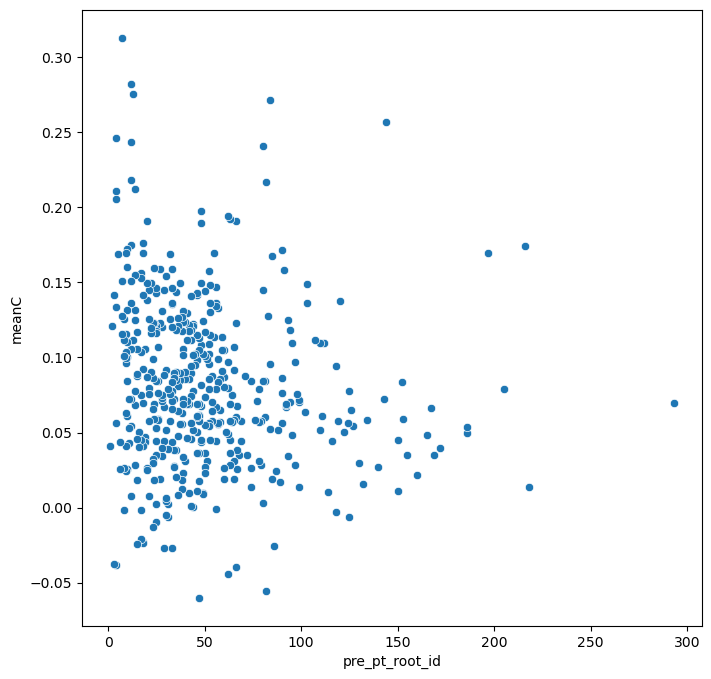

In [11]:
# make a scatter plot of the mean correlation vs the number
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=df, x='pre_pt_root_id', y='meanC')

<Axes: xlabel='pre_pt_root_id', ylabel='stdC'>

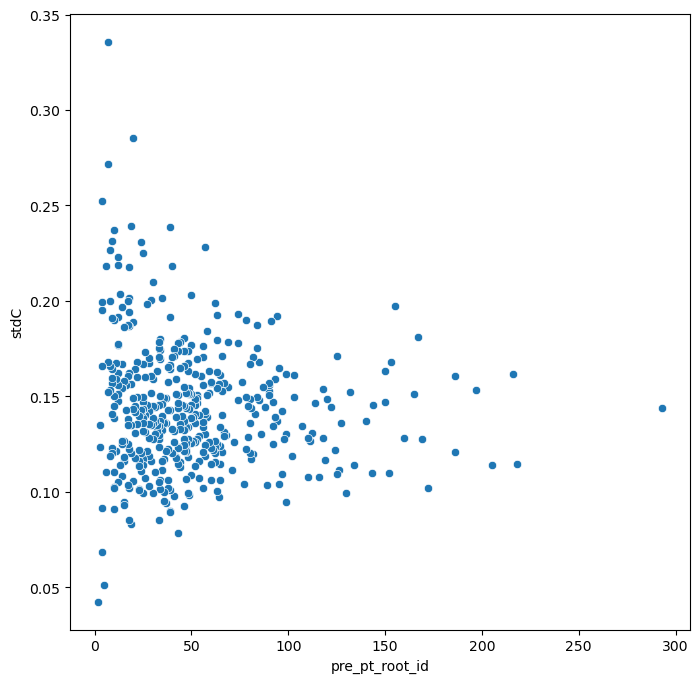

In [12]:
# make a scatter plot of the mean correlation vs the standard deviation
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=df, x='pre_pt_root_id', y='stdC')

In [13]:
# now do the same thing by post-synaptic cell

# count the connections by post synaptic cell
counts=all_syn_dfm3.post_pt_root_id.value_counts()
# look at the top 10
counts.iloc[0:10]

864691135565831447    48
864691135763046710    47
864691135866737541    44
864691135946651940    37
864691136310417242    36
864691136953057759    33
864691136990735509    32
864691135156592740    32
864691136371715976    32
864691136484016428    31
Name: post_pt_root_id, dtype: int64

In [14]:
# find the average correlation and standard deviations of correlations for each individual cell
# hint: use group by
avgC=all_syn_dfm3.groupby('post_pt_root_id').C.mean()
avgC.name= 'meanC'
stdC = all_syn_dfm3.groupby('post_pt_root_id').C.std()
stdC.name = 'stdC'
post_df = pd.DataFrame([counts, avgC, stdC]).T


In [15]:
post_df.head()

,post_pt_root_id,meanC,stdC
864691135565831447,48.0,0.035621,0.149198
864691135763046710,47.0,0.072946,0.113165
864691135866737541,44.0,0.069008,0.178217
864691135946651940,37.0,-0.016057,0.176549
864691136310417242,36.0,0.079361,0.155609


<Axes: xlabel='post_pt_root_id', ylabel='meanC'>

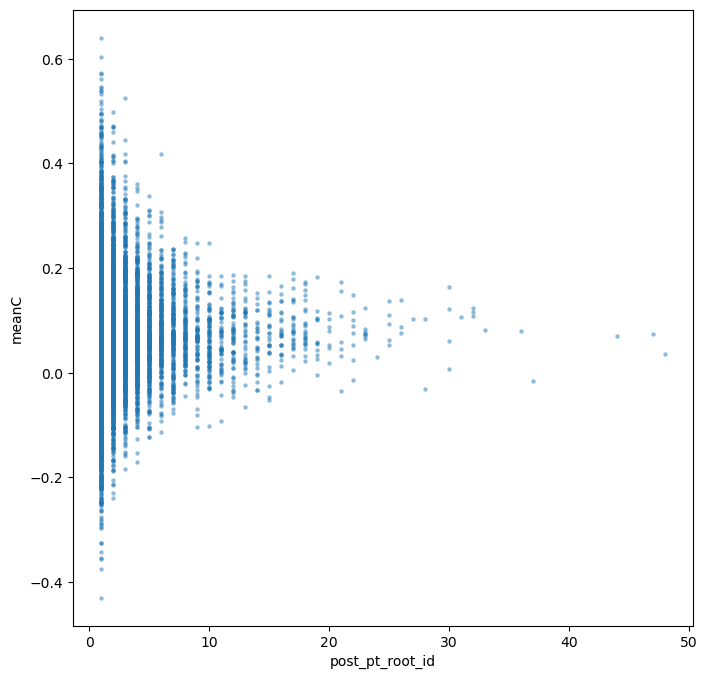

In [16]:
# make a scatter plot of the mean correlation vs the number
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=post_df, s=10, x='post_pt_root_id', y='meanC', linewidth=0, alpha=.5)

In [17]:
# are there any cells that have a lot of mapped inputs and outputs?

# combine the pre and post dataframes into one

comb_df = pd.merge(df, post_df, left_index=True, right_index=True, how='inner', suffixes=['pre', 'post'])
comb_df.head()

,pre_pt_root_id,meanCpre,stdCpre,post_pt_root_id,meanCpost,stdCpost
864691136521831825,293.0,0.069778,0.143706,2.0,0.290633,0.197911
864691135473091634,218.0,0.013846,0.114538,19.0,0.034161,0.116972
864691136084747372,216.0,0.174026,0.161509,5.0,0.059619,0.154136
864691135701034107,205.0,0.079112,0.114086,9.0,0.068209,0.151403
864691135975539779,197.0,0.169778,0.153481,5.0,0.101536,0.155701


<Axes: xlabel='pre_pt_root_id', ylabel='post_pt_root_id'>

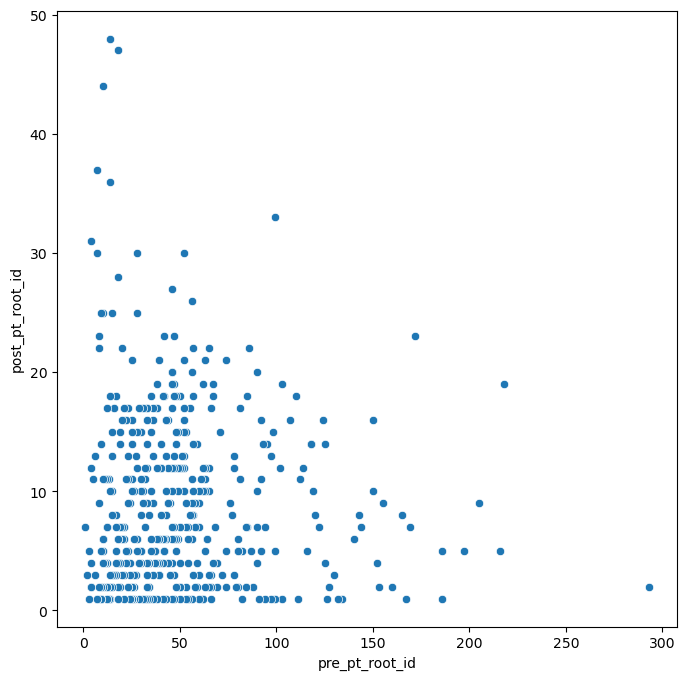

In [18]:
# make a scatter plot of the N of inputs and outputs
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=comb_df, x='pre_pt_root_id', y='post_pt_root_id', ax=ax)

<Axes: xlabel='meanCpre', ylabel='meanCpost'>

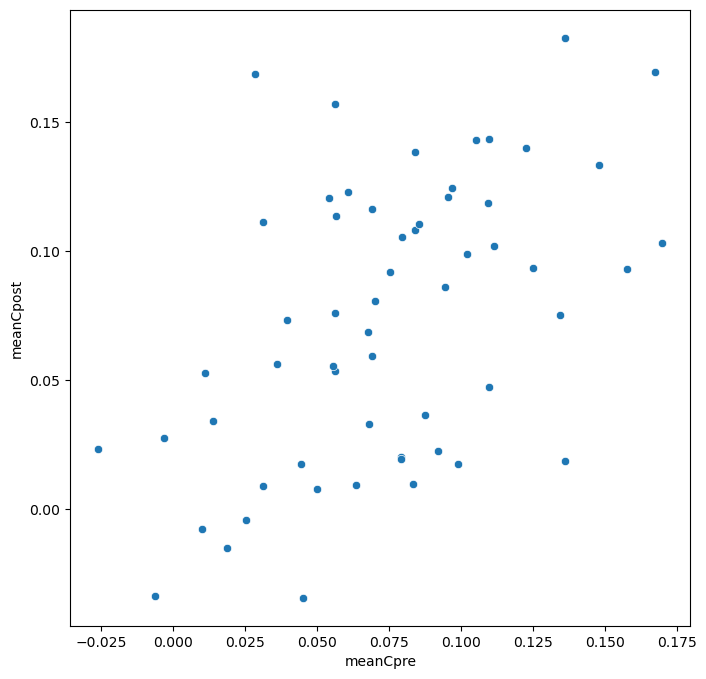

In [19]:
# filter out the cells with low N from both conditions
# and make a scatter plot of the avg mean correlation of inputs vs outputs
Nthreshold = 18
f, ax = plt.subplots(figsize=(8,8))
comb_df_filt = comb_df.query('pre_pt_root_id>50').query('post_pt_root_id>10')
sns.scatterplot(data=comb_df_filt, x='meanCpre',y='meanCpost', ax=ax)

In [20]:
# what is the correlation between those values and its P value?
scipy.stats.pearsonr(comb_df_filt.meanCpre, comb_df_filt.meanCpost)

PearsonRResult(statistic=0.5027850109581278, pvalue=5.767219005532883e-05)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Follow-up questions - extensions

 What might explain this variation from cell to cell?
   ### Biological ideas
   
   a) Cell types.  Do you see these high and low effect cells more in certain cell types?  What is a good null model for this?
   
   b) Different connectivity in the heirachy.  Do cells that axon project in different directions correlate with this effect?
   
   c) Different levels of inhibition.  Perhaps inhibitory circuits are somehow modulating plasticity in these cells.
      Does the amount on total excitatory or inhibitory input vary in these high vs low cells.
    
   ### Technical issues
   a) Reconstruction quality.  Are the axons of the more correlated cells better reconstructed?
      Examining the reconstructions of the low effect vs high effect cells could give insight into this.

   
   ### Hybrid issues
   a) Visual Responsivness/Model Fit: Does the in silico response accurately reflect this cells firing? We know that cells with low oracle scores (avg correlation between repeated visual stimuli) are poorly fit by the model.  These cells are not visually reliable.  Being visually unreliable means activity is not as correlated to the same stimulus, and a hebbian hypotheses would predict that plasticity would not be as effective for cells that are like this. 
   
   a) Space: See space exercise.  What if cells in certain regions show this effect more or less,
      what if synapses that are farther or closer to the cell are more prone to this effect?
      
   b) Synapse size: see size exercise. What if the reconstructions from some cells have more larger synapses than others and synapse size is a strong correlated of this effect? 
   